In [27]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import ast
from keras.optimizers import SGD


In [28]:
# Load the dataset
def load_data(file_path, max_length=30):
    data = pd.read_csv(file_path)
    data['Footprint'] = data['Footprint'].apply(lambda x: ast.literal_eval(x))

    # Pad sequences to ensure uniform length
    X = pad_sequences(data['Footprint'].tolist(), maxlen=max_length, padding='post', truncating='post')
    y = data['Label'].values
    return X, y

# Specify the file path
file_path = '/content/processed_dataset.csv'
X, y = load_data(file_path)


In [29]:
# Define a function to build the model
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, 1, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv1D(128, 1, activation='relu'),
        tf.keras.layers.Conv1D(128, 1, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    learning_rate = 0.1
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [30]:
# Define the training process with noise handling
def train_with_noise_handling(X, y, num_iterations=10, learning_rate=0.01):
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Build the model
    model = build_model(input_shape=(X.shape[1], 1), num_classes=len(label_encoder.classes_))

    # Initial training and store history
    history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=5, validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val))

    # Noise handling loop
    for iteration in range(num_iterations):
        # Step 2: Estimate label distributions
        label_distributions = model.predict(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))

        # Update the training labels based on predictions
        y_train = np.argmax(label_distributions, axis=1)

        # Step 3: Fine-tune the model and store history
        history_iteration = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=5, validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val))

        # Combine histories
        history.history['loss'] += history_iteration.history['loss']
        history.history['accuracy'] += history_iteration.history['accuracy']
        history.history['val_loss'] += history_iteration.history['val_loss']
        history.history['val_accuracy'] += history_iteration.history['val_accuracy']

    return model, label_encoder, X_val, y_val, history

# Train the model
model, label_encoder, X_val, y_val, history = train_with_noise_handling(X, y)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1084/1084 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7332 - loss: 0.9152 - val_accuracy: 0.7894 - val_loss: 0.6691
Epoch 2/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7922 - loss: 0.6458 - val_accuracy: 0.8034 - val_loss: 0.6307
Epoch 3/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8011 - loss: 0.6112 - val_accuracy: 0.7965 - val_loss: 0.6297
Epoch 4/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7976 - loss: 0.5999 - val_accuracy: 0.8011 - val_loss: 0.6249
Epoch 5/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8029 - loss: 0.5817 - val_accuracy: 0.8034 - val_loss: 0.6197
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Epoch 1/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9714 - loss: 0.1037 - val_accuracy: 0.8042 - val_loss: 1.6184
Epoch 2/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9829 - loss: 0.0520 - val_accuracy: 0.8027 - val_loss: 1.9724
Epoch 3/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/

In [31]:
# Function to evaluate the model
def evaluate_model(model, label_encoder, X_val, y_val):
    y_pred_probs = model.predict(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate the model
evaluate_model(model, label_encoder, X_val, y_val)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.7988
Precision: 0.7525
Recall: 0.7988
F1 Score: 0.7721


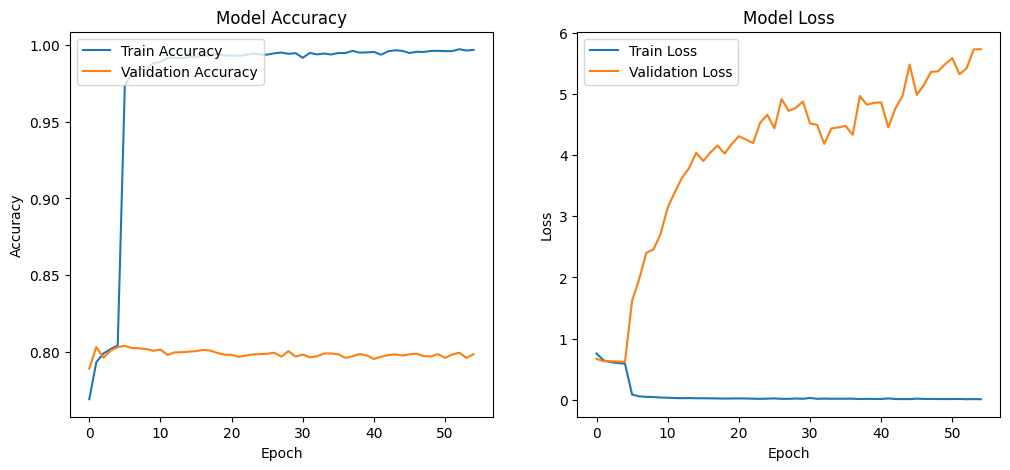

In [32]:
# Function to plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

# Plot training history
plot_history(history)
